In [1]:
# Decision Tree Implemetation with Prepruning 
# Author: Ayhan Okuyan
# Last Modified: Nov 2020

# Note: To run this implementation, all the dependencies and graph must be installed.
# For MacOS versions, graphviz can be installed using homebrew: 'brew install graphviz'
# For other OS versions, check https://graphviz.org/download/

# To run, initialize a DecisionTree instance
# run DecisionTree.train(features, labels, args)
# features and labels are data matrices. 
# args: choice represents impurity, can be 'gini' or 'entropy', default is 'gini'
# args: prun is the prepruning option, can be either ['depth', maxDepth] or ['gain', minGain], default is ['none']
# depth prepruning option uses depth to stop if the current depth is greater than the maxDepth
# gain prepruning option uses gain to stop if the current gain is smaller than the minGain

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from graphviz import Digraph
import matplotlib.colors as colors
import matplotlib.cm as cm


In [2]:
#load train_data
#set current working directory
cwd = os.getcwd()
#load train data as csv
train_data = pd.read_csv(os.path.join(cwd, 'train_data.txt'), sep=' ', header=None)
train_data.reset_index(drop=True, inplace=True)
train_data = train_data.to_numpy()[:,:-2]

#load test data as csv
test_data = pd.read_csv(os.path.join(cwd, 'test_data.txt'), sep=' ', header=None)
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.to_numpy()[:,:-2]

#convert to features and labels
print(train_data.shape)
print(test_data.shape)

numFeatures = train_data.shape[1]
train_features = train_data[:,:numFeatures-1]
train_labels = train_data[:,numFeatures-1]
test_features = test_data[:,:numFeatures-1]
test_labels = test_data[:,numFeatures-1]

print(train_features.shape)
print(train_labels.shape)

(3772, 22)
(3428, 22)
(3772, 21)
(3772,)


In [3]:
#load feature names 
costMatrix = pd.read_csv(os.path.join(cwd, 'thy_cost.txt'), sep=':', header=None)

featNames = costMatrix.to_numpy()[:,0]
featNames = np.append(featNames, 'extracted')
print(featNames)
featNames = np.append(featNames,'pure')

['age' 'sex' 'on_thyroxine' 'query_on_thyroxine'
 'on_antithyroid_medication' 'sick' 'pregnant' 'thyroid_surgery'
 'I131_treatment' 'query_hypothyroid' 'query_hyperthyroid' 'lithium'
 'goitre' 'tumor' 'hypopituitary' 'psych' 'TSH' 'T3' 'TT4' 'T4U'
 'extracted']


In [4]:
def gini(nodeLabels):
    labels, counts = np.unique(nodeLabels, return_counts=True)
    gini = 0
    all_counts = np.sum(counts)
    for i in range(len(labels)):
        gini += (counts[i]/all_counts)**2 
    gini_imp = (1 - gini)
    return gini_imp   

def entropy(nodeLabels):
    labels, counts = np.unique(nodeLabels, return_counts=True)
    entropy = 0
    all_counts = np.sum(counts)
    for i in range(len(labels)):
        entropy -= (counts[i]/all_counts)*np.log2(counts[i]/all_counts)
    return entropy   

def calcImpurity(nodeLabels, impurity):
    if(impurity == 'gini'):
        return gini(nodeLabels)
    elif(impurity == 'entropy'):
        return entropy(nodeLabels)
    else:
        raise Exception("Invalid choice of Impurity: " + impurity[0])
        
def calcSplitImpurity(feature, labels, val, impurity):
    left_split = labels[feature <= val]
    p_left = len(left_split)/len(labels)
    right_split = labels[feature > val]
    return p_left * calcImpurity(left_split, impurity) + (1-p_left) * calcImpurity(right_split, impurity)

def calcInfoGain(feature, labels, val, choice):
    entropy = calcImpurity(labels, choice)
    split_entropy = calcSplitImpurity(feature, labels, val, choice)
    return entropy - split_entropy

def bestSplitofFeature(feature, labels, choice):
    bestSplitCrit = np.inf
    threshold = np.inf
    infGain = -1
    
    for val in feature:
        splitCrit = calcSplitImpurity(feature, labels, val, choice)
        
        if(splitCrit <= bestSplitCrit):
            bestSplitCrit = splitCrit;
            threshold = val
            infGain = calcInfoGain(feature, labels, val, choice)
    return bestSplitCrit, threshold, infGain

def bestSplit(features, labels, choice):
    featureIndex = 21
    bestSplitCrit = np.inf
    threshold = np.inf
    best_gain = -1

    for i in range(features.shape[1]):
        
        feature_oi = features[:,i]
        splitCrit, thr, gain = bestSplitofFeature(feature_oi, labels, choice)
        
        if(splitCrit <= bestSplitCrit):
            bestSplitCrit = splitCrit
            featureIndex = i
            threshold = thr
            best_gain = gain
    
    left_features = features[features[:,featureIndex] <= threshold]
    left_labels = labels[features[:,featureIndex] <= threshold]
    
    right_features = features[features[:,featureIndex] > threshold]
    right_labels = labels[features[:,featureIndex] > threshold]
    
    bestSplitCrit = calcImpurity(labels, choice) #return impurity of node to plot
    
    return threshold, featureIndex, best_gain, bestSplitCrit,left_features, left_labels, right_features, right_labels

class Node():
    def __init__(self, depth, parent):
        #for if not pure -> -1, else label 
        self.leaf_label = -1
        #parent link and children links
        self.parent = parent
        self.children = []
        #feature of split and split value
        self.split = 0.5
        self.split_index = 21
        # impurity or split criterion value
        self.split_crit = 0.0
        #depth of node
        self.depth = depth   
        # for plottling, each node is given an id
        self.id = 0
        # record split and classes to plot the tree like sklearn does
        self.numSamples = 0
        self.labels = []
        self.label_counts = []
        
    def formatLabel(self):
        formattedStr = '['
        for lb,ct in zip(self.labels, self.label_counts):
            formattedStr += str(int(lb)) + ': ' + str(ct) + ', '
        formattedStr = formattedStr[:-2] + ']'
        return formattedStr
    
def createTree(node, features, labels, choice, prun): 
    #find (label, count) pairs to plot
    node.numSamples = len(labels)
    lbs,cts = np.unique(labels, return_counts = True)
    node.labels = lbs
    node.label_counts = cts
        
    # is pure
    if(np.min(labels) == np.max(labels)):
        lbs, cts = np.unique(labels, return_counts=True)
        node.leaf_label = lbs[np.argmax(cts)]
        return      
    # prepruning for depth
    elif(prun[0] == 'depth' and node.depth == prun[1]):
        lbs, cts = np.unique(labels, return_counts=True)
        node.leaf_label = lbs[np.argmax(cts)]
        return
    else:
        split_val, split_feat_index, infGain, split_crit, left_features, left_labels, right_features, right_labels = \
        bestSplit(features, labels, choice)
        
        #print(featNames[split_feat_index])
        
        #prepruning for information gain
        if(prun[0] == 'gain' and infGain <= prun[1]):
            lbs, cts = np.unique(labels, return_counts=True)
            node.leaf_label = lbs[np.argmax(cts)]
            return
        
        node.split_crit = split_crit
        
        node.split = split_val
        node.split_index = split_feat_index
                
        left_child = Node(node.depth+1, node)
        right_child = Node(node.depth+1, node)
        node.children.append(left_child)
        node.children.append(right_child)
        createTree(left_child, left_features, left_labels, choice, prun)
        createTree(right_child, right_features, right_labels, choice, prun)

def predictSample(node, inp):
    if(node.leaf_label != -1):
        return node.leaf_label
    else:
        if(inp[node.split_index] <= node.split):
            pred = predictSample(node.children[0], inp)
        else:
            pred = predictSample(node.children[1], inp)
        return pred
    
def generateColorPalette(num, cmap):
    colormap = cm.get_cmap(cmap, num)
    newcolors = colormap(np.linspace(0, 1, num))
    return newcolors

def getColor(palette, ind):
    color = palette[ind,:]
    rgb = str(colors.to_hex(color))
    if (color[0]*0.299 + color[1]*0.587 + color[2]*0.114) > (186/256):
        textColor = '#000000' 
    else:
        textColor = '#ffffff'
    return (rgb, textColor)

class TreeClassifier():
    def __init__(self):
        self.tree = None
        self.choice = ['gini']
        self.prun = ['none']
        
    def train(self, features, labels, choice=['gini'], prun=['none']):
        
        self.choice = choice
        self.prun = prun

        root = Node(0, None)
        createTree(root, features, labels, choice, prun)
        self.tree = root
    def predict(self, inp):
        if self.tree != None:
            res = []
            for i in range(inp.shape[0]):
                res.append(predictSample(self.tree, inp[i,:]))
            return np.asarray(res)
        else:
            print('Can\'t predict before training')
            return -1
            
    def traintestresults(self, train_features, train_labels, test_features, test_labels):
        #TRAINING ACCURACIES
        train_pred = self.predict(train_features)
        #print(train_pred.shape, train_pred.min(), train_pred.max())
        print('Training Accuracy: %.3f%%' % (np.sum(train_pred==train_labels)
              /train_pred.shape[0]*100))
        numSamples = np.zeros(3)
        truePreds =  np.zeros(3)
        for sample, result in zip(train_labels, train_pred):
            numSamples[int(result)-1] += 1
            if(sample == result):
                truePreds[int(result)-1] += 1
        classAccs = truePreds/numSamples*100
        print('Class-Based Accuracies:')
        for i in range(3):
            print('Accuracy of Class %d: %.3f%%' % (i+1,classAccs[i]))
        cm = confusion_matrix(train_labels, train_pred, labels=[1,2,3])
        cm_display = ConfusionMatrixDisplay(cm, display_labels=[1,2,3]).plot()
        plt.title('Confusion Matrix for Training Data')
        plt.show()

        #TEST ACCURACIES
        test_pred = self.predict(test_features)
        #print(test_pred.shape, test_pred.min(), test_pred.max())
        print('Test Accuracy: %.3f%%' % (np.sum(test_pred==test_labels)
              /test_pred.shape[0]*100))
        numSamples = np.zeros(3)
        truePreds =  np.zeros(3)
        for sample, result in zip(test_labels, test_pred):
            numSamples[int(result)-1] += 1
            if(sample == result):
                truePreds[int(result)-1] += 1
        classAccs = truePreds/numSamples*100
        print('Class-Based Accuracies:')
        for i in range(3):
            print('Accuracy of Class %d: %.3f%%' % (i+1,classAccs[i]))

        cm = confusion_matrix(test_labels, test_pred, labels=[1,2,3])
        cm_display = ConfusionMatrixDisplay(cm, display_labels=[1,2,3]).plot()
        plt.title('Confusion Matrix for Test Data')
        plt.show()

    def plotTree(self, names, precision=3, cmap='RdBu', save=False, filename='tree', format='png'):
        if(self.tree == None):
            print("Train to show tree")
            return
        
        palette = generateColorPalette(len(names)+1, cmap)
        
        univ_id = 0
        g = Digraph(name = 'tree', filename = filename, format=format, 
                    graph_attr = {'ranksep': 'equally'},
                    node_attr={'shape': 'rectangle', 'fontname': 'helvetica', 'fontsize':'10', 'dpi':'300',
                              'margin': '0.03,0.03'})

        current_level = [self.tree]
        
        #prep_label
        label = names[self.tree.split_index] + '<=' + str(round(self.tree.split, precision)) + '\n'
        label += self.choice + '=' + str(round(self.tree.split_crit,precision)) + '\n'
        label += 'samples: ' + str(self.tree.numSamples) + '\n'
        label += 'value: ' + self.tree.formatLabel()
        
        #Assign 1 to root node
        colors = getColor(palette, self.tree.split_index)
        g.node("node_1", label= label, style='filled',fillcolor=colors[0], fontColor=colors[1])
        while current_level:
            for node in current_level:
                univ_id += 1
                node.id = univ_id 
                if node.parent != None:
                    if node.leaf_label != -1:
                        label = 'majority class: ' + str(int(node.leaf_label)) + '\n'
                        label += 'samples: ' + str(node.numSamples) + '\n'
                        label += 'value: ' + node.formatLabel()
                    else:  
                        label = names[node.split_index] + '<=' + str(round(node.split, precision)) + '\n'
                        label += self.choice + '=' + str(abs(round(node.split_crit, precision))) + '\n'
                        label += 'samples: ' + str(node.numSamples) + '\n'
                        label += 'value: ' + node.formatLabel()
                    
                    colors = getColor(palette,node.split_index)
                    g.node("node_" + str(node.id), label=label, style='filled',fillcolor=colors[0], fontcolor=colors[1])
                    g.edge("node_" + str(node.parent.id), "node_" + str(node.id))

            next_level = list()
            for node in current_level:
                if node.leaf_label == -1:
                    next_level.append(node.children[0])
                    next_level.append(node.children[1])
            current_level = next_level
        if(save):
            g.view()
        return g
    
    def getChoiceString(self):
        if self.choice[0] == 'nunez':
            return self.choice[0] + ' (w=%.2f)' % self.choice[1]
        else:
            return self.choice[0]

choice: [gini], [entropy], [tan]w/CostVector, [nunez,w]w/CostVector

Training Accuracy: 99.708%
Class-Based Accuracies:
Accuracy of Class 1: 98.936%
Accuracy of Class 2: 95.025%
Accuracy of Class 3: 100.000%


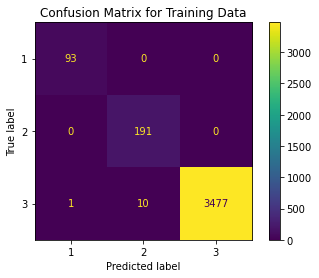

Test Accuracy: 99.271%
Class-Based Accuracies:
Accuracy of Class 1: 91.026%
Accuracy of Class 2: 92.147%
Accuracy of Class 3: 99.905%


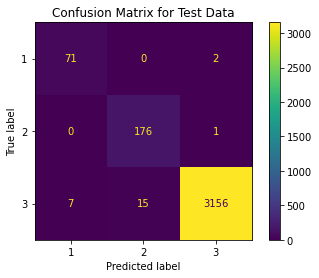

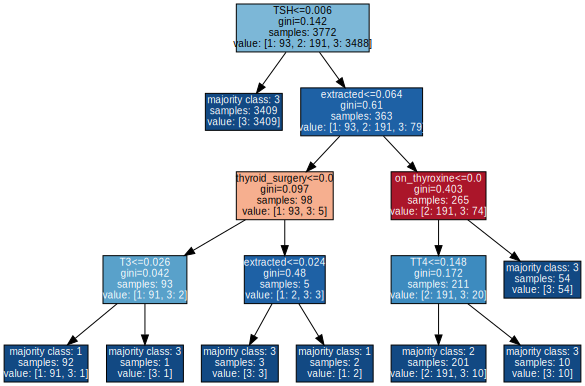

In [15]:
#BEST wITH DEPTH
tree = TreeClassifier()
tree.train(train_features, train_labels, choice='gini', prun=['depth', 4])
tree.traintestresults(train_features, train_labels, test_features, test_labels)
tree.plotTree(featNames, cmap='RdBu', save=False, filename='images/p2_gini_depth_5')

Training Accuracy: 99.788%
Class-Based Accuracies:
Accuracy of Class 1: 94.898%
Accuracy of Class 2: 98.454%
Accuracy of Class 3: 100.000%


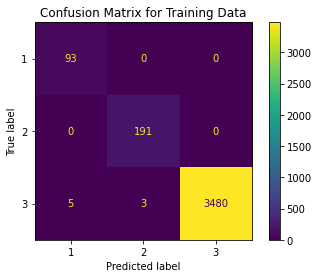

Test Accuracy: 99.329%
Class-Based Accuracies:
Accuracy of Class 1: 86.905%
Accuracy of Class 2: 94.118%
Accuracy of Class 3: 99.968%


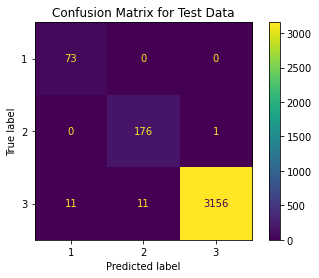

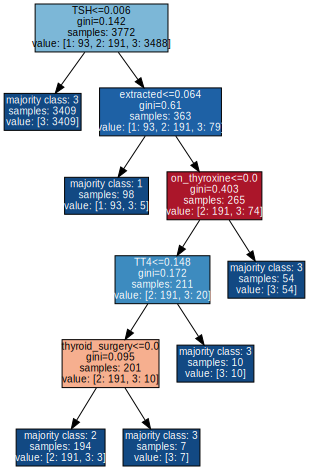

In [8]:
#BEST WITH GAIN
tree = TreeClassifier()
tree.train(train_features, train_labels, choice='gini', prun=['gain', 0.05])
tree.traintestresults(train_features, train_labels, test_features, test_labels)
tree.plotTree(featNames, cmap='RdBu', save=True, filename='images/p2_gini_gain_0.05')

Training Accuracy: 100.000%
Class-Based Accuracies:
Accuracy of Class 1: 100.000%
Accuracy of Class 2: 100.000%
Accuracy of Class 3: 100.000%


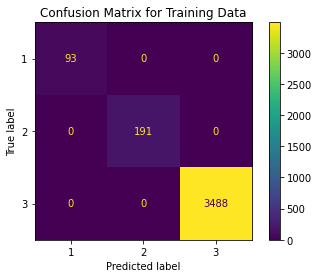

Test Accuracy: 99.183%
Class-Based Accuracies:
Accuracy of Class 1: 90.141%
Accuracy of Class 2: 94.118%
Accuracy of Class 3: 99.685%


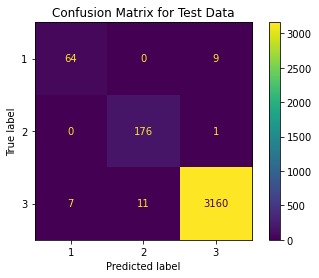

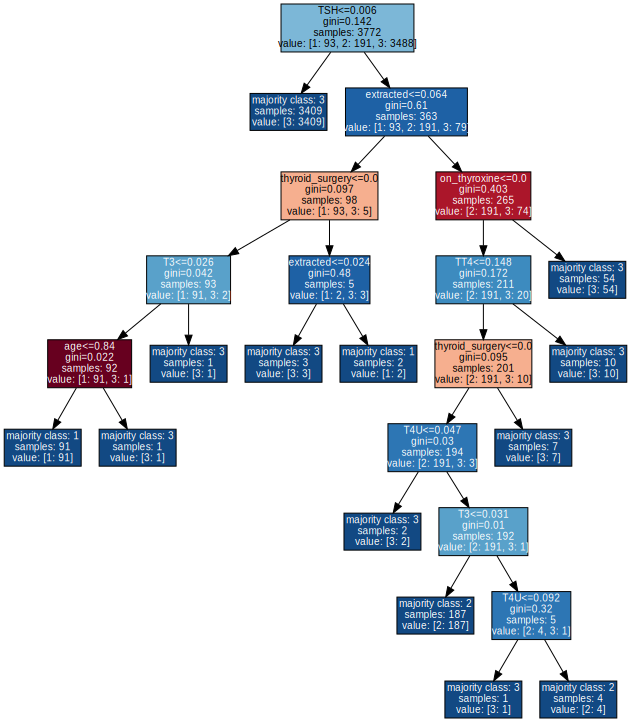

In [12]:
#BASE CASE
tree = TreeClassifier()
tree.train(train_features, train_labels, choice='gini', prun=['none'])
tree.traintestresults(train_features, train_labels, test_features, test_labels)
tree.plotTree(featNames, cmap='RdBu', save=False, filename='images/p2_gini_gain_0.05')